# Introduction: Feature Preprocessing

Feature preprocessing refers to the general process of preparing a dataset for machine learning. The features (also known as predictors, explanatory variables, or inputs) to a machine learning model must be in a single data structure where each row contains one observation and the columns are the features. The feature values in this data structure (here we will be using a `dataframe`) must all be numbers and there must be no missing values. In a supervised learning task, we have two sets of features, a training set and a testing set. The training set is provided by the model during training along with the targets (the values we want to predict) so the model can learn a mapping between these features and the target. During testing, the model makes predictions on data points (observations) it has not seen before which can be compared to the test labels to determine the model performance. The result of feature preprocessing is a set of training features and a set of testing features that can be for model training and prediction. Feature preprocessing encompasses two processes:

* [Feature engineering](https://en.wikipedia.org/wiki/Feature_engineering) (also called feature construction): building new features out of the existing data. This can take on many forms such as extracting the month from a datetime, adding interaction terms between two variables, or taking the natural log transform of a column. Feature engineering adds additional features designed to help the model learn the mapping from features to the target. [This is a crucial step](https://www.featurelabs.com/blog/secret-to-data-science-success/) in machine learning because a model can only learn from the data we provide to it during training.
* Feature selection (also called dimensionality reduction): reducing the number of features by selecting those that are "most relevant" for a task. The definition pf relevance will depend on the task, but the basic idea of feature selection is to remove redundant or irrelevant variables. Having too many features makes it more difficult for a model to learn, a problem known as the ["curse of dimensionality."](https://en.wikipedia.org/wiki/Curse_of_dimensionality) The number of data points needed for a model to learn scales exponentially with the number of features, and selecting the most relevant can significantly improve training and generalization performance on the test set. 

In this notebook, we will walk through feature preprocessing for the building energy prediction problem. We will focus on feature engineering and extracting as much information as possible from the existing data. As we will see, the number of features, even after feature construction, is not large compared to the number of observations, so we will not perform feature selection (later we can work on feature selection using measures such as feature importance or the variance of a feature). 

The building energy prediction problem is a supervised regression task. We are given a dataset of past energy use and weather conditions and will build a model that can learn to predict energy consumption. We have the targets - the energy consumption - and during training our model learns a mapping from the features to the target. Then, during testing, we have the model make predictions on new observations it has not previously seen which we can compare to the known testing targets to assess performance. 

We will first go through the preprocessing steps one at a time, and then [refactor all of the code](https://en.wikipedia.org/wiki/Code_refactoring) into a single function that can be re-used in future work. 

### Packages

We will use a standard set of data science packages: `pandas`, `numpy`, `sklearn` (Scikit-Learn), `matplotlib`. To see the correct package versions, please refer to the `requirements.txt` file.

In [1]:
# numpy and pandas for data manipulation
import pandas as pd
import numpy as np

# Sklearn preprocessing functionality
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Matplotlib for visualizations
import matplotlib.pyplot as plt

# Adjust default font size 
plt.rcParams['font.size'] = 18

### Read in Dataset

We will read the data into a [pandas `dataframe`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html), an extremely useful data structure for data science. 

In [2]:
# Read in the data
df = pd.read_csv('../data/f-Kansas_weather.csv')
df.head()

,timestamp,elec_cons,elec_cons_imp,pow_dem,biz_day,day_of_week,week_day_end,sun_rise_set,num_time,cleaned_energy,anom_flag,ghi,dif,gti,temp,rh,pwat,ws,forecast,anom_missed_flag
0,2015-12-18 12:00:00,9.588,0,17.256,1,Fri,day,rise,12.00,9.588,0,490,62,957,3.5,37.6,4.4,5.8,9.588,0
1,2015-12-18 12:15:00,10.020,0,1.728,1,Fri,day,NaN,12.25,10.020,0,490,62,958,3.7,36.8,4.5,5.8,10.020,0
2,2015-12-18 12:30:00,9.684,0,-1.344,1,Fri,day,NaN,12.50,9.684,0,486,62,955,4.0,36.1,4.6,5.8,9.684,0
3,2015-12-18 12:45:00,10.170,0,1.944,1,Fri,day,NaN,12.75,10.170,0,479,62,949,4.3,35.3,4.7,8.1,10.170,0
4,2015-12-18 13:00:00,9.630,0,-2.160,1,Fri,day,NaN,13.00,9.630,0,468,61,941,4.5,34.6,4.7,8.1,9.630,0


The first step is to convert the `NaN` values in the `sun_rise_set` column into `neither`. This will prevent pandas and numpy from treating these values as numbers.

In [3]:
# Fill in NaN values 
df['sun_rise_set'] = df['sun_rise_set'].fillna('neither')

## Time Variables

The energy consumption of a building is highly dependent on time. Therefore, we need to work on extracting as much information as possible from the time information. To do this, we can first convert the `timestamp` column to a [pandas `DatetimeIndex`](https://pandas.pydata.org/pandas-docs/version/0.21/generated/pandas.DatetimeIndex.html) object and extract the day of the year (`yday`), month of the year (`month`), and the day of the week (`wday`). The hour of the day and minute of the hour is already recorded in the `num_time` column which records the time of the day in fractions of an hour on a 24-hour clock. For example, 4:45 pm is represented as 16.75 in the `num_time` column.

In [4]:
# Convert to a datetime index
df['timestamp'] = pd.DatetimeIndex(df['timestamp'])

# Create new time features
df['yday'] = df['timestamp'].dt.dayofyear
df['month'] = df['timestamp'].dt.month
df['wday'] = df['timestamp'].dt.dayofweek

df.head()

,timestamp,elec_cons,elec_cons_imp,pow_dem,biz_day,day_of_week,week_day_end,sun_rise_set,num_time,cleaned_energy,...,gti,temp,rh,pwat,ws,forecast,anom_missed_flag,yday,month,wday
0,2015-12-18 12:00:00,9.588,0,17.256,1,Fri,day,rise,12.00,9.588,...,957,3.5,37.6,4.4,5.8,9.588,0,352,12,4
1,2015-12-18 12:15:00,10.020,0,1.728,1,Fri,day,neither,12.25,10.020,...,958,3.7,36.8,4.5,5.8,10.020,0,352,12,4
2,2015-12-18 12:30:00,9.684,0,-1.344,1,Fri,day,neither,12.50,9.684,...,955,4.0,36.1,4.6,5.8,9.684,0,352,12,4
3,2015-12-18 12:45:00,10.170,0,1.944,1,Fri,day,neither,12.75,10.170,...,949,4.3,35.3,4.7,8.1,10.170,0,352,12,4
4,2015-12-18 13:00:00,9.630,0,-2.160,1,Fri,day,neither,13.00,9.630,...,941,4.5,34.6,4.7,8.1,9.630,0,352,12,4


## Cyclical Variable Representation

[Time variables are inherently cyclical](https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/) and a typical ordered representation of time does not capture the actual relationship between different times. For example, using hours on a 1-24 scale means that hour 22 is represented as being closer to hour 10 (a 12 hour difference) than to hour 0 (a 22 hour difference). However, behavior at hour 0 is most likely closer to that at hour 22 because the actual time difference is 2 hours. 

[In order to properly represent cyclical continuous variables](https://datascience.stackexchange.com/questions/5990/what-is-a-good-way-to-transform-cyclic-ordinal-attributes), we need to transform these features into sinusoids by taking the sine and cosine of the variable using the appropriate period. For the hour example, the equations are as follows:

$$\text{hour sine} = \text{sin}(\frac{2 * \pi * \text{hour}}{24})$$

$$\text{hour cosine} = \text{cos}(\frac{2 * \pi * \text{hour}}{24})$$

We have to include both the sine and cosine transformations in order to break the symmetry from using only a single sinusoid. 

There are four time variables that are cyclical and need to be transformed:

* `yday`: day of the year, period = 365
* `month`: month of the year, perdiod = 12
* `wday`: day of the week, period = 6 (this variable goes from 0 to 6)
* `num_time`: time of the day, period = 24

To determine the proper period in the code, we can divide by the maximum value in the data. This handles the edge cases where we have datasets that do not have all 12 months or days of the year up to 365. 

Let's show one example of cyclical variable transformations using `num_time`, the time of day in hours. First we can plot the variable in its standard representation.

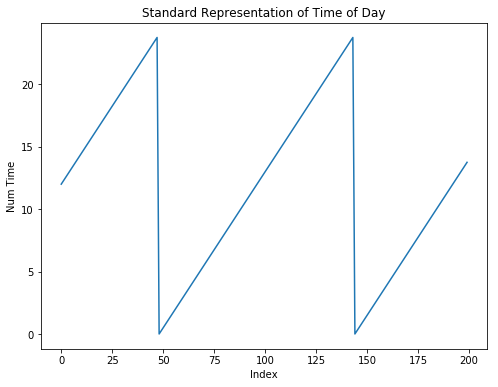

In [5]:
plt.figure(figsize = (8, 6))

# Make the plot of num time versus the index 
plt.plot(list(range(200)), df['num_time'][:200])

# Label the plot
plt.xlabel('Index'); plt.ylabel('Num Time'); plt.title('Standard Representation of Time of Day');

The graph is not continuous and does not represent the proper distance between times of the day.

To correct this, we take the sine and cosine transformations with the appropriate period. Then we plot the results to see how this transformation works.

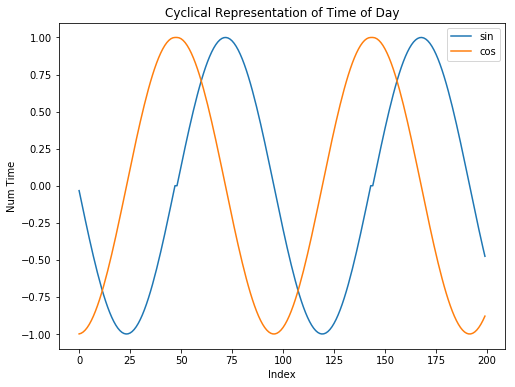

In [6]:
# Make the transformed variables
df['num_time_sin'] = np.sin(2 * np.pi * df['num_time'] / df['num_time'].max())
df['num_time_cos'] = np.cos(2 * np.pi * df['num_time'] / df['num_time'].max())

plt.figure(figsize = (8, 6))

# Plot the results
plt.plot(list(range(200)), df['num_time_sin'][:200], label = 'sin')
plt.plot(list(range(200)), df['num_time_cos'][:200], label = 'cos')
plt.legend();
plt.xlabel('Index'); plt.ylabel('Num Time'); plt.title('Cyclical Representation of Time of Day');

The time of day is now represented as two continuous variables with the proper relationship between times. This will allow a machine learning model to learn the actual relationship between the time of day and the energy consumption.

We can apply the same transformation to the four variables which are cyclical. 

In [7]:
cyc_features = ['yday', 'month', 'wday', 'num_time'] 

# Iterate through the variables
for feature in cyc_features:
    df['%s_sin' % feature] = np.sin(2 * np.pi * df[feature] / df[feature].max())
    df['%s_cos' % feature] = np.cos(2 * np.pi * df[feature] / df[feature].max())

We can remove the ordered representations of the time because all the information has now been encoded in the transformations. We can also remove the `day_of_week` column because that has been represented by `wday`. 

In [8]:
# Remove the ordered time features
df = df.drop(columns = ['yday', 'month', 'wday', 'num_time', 'day_of_week'])

The last step to take with the time features is to convert the `timestamp` into a number. We can do this by representing the time as the number of seconds since the beginning of the data. If there is an overall trend to the energy consumption, this variable will allow the model to learn the trend.

In [9]:
# Convert the timestamp to total seconds since beginning of data
df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()
df.head()

,timestamp,elec_cons,elec_cons_imp,pow_dem,biz_day,week_day_end,sun_rise_set,cleaned_energy,anom_flag,ghi,...,forecast,anom_missed_flag,num_time_sin,num_time_cos,yday_sin,yday_cos,month_sin,month_cos,wday_sin,wday_cos
0,0.0,9.588,0,17.256,1,day,rise,9.588,0,490,...,9.588,0,-0.033063,-0.999453,-0.221922,0.975065,-2.449294e-16,1.0,-0.866025,-0.5
1,900.0,10.020,0,1.728,1,day,neither,10.020,0,490,...,10.020,0,-0.099046,-0.995083,-0.221922,0.975065,-2.449294e-16,1.0,-0.866025,-0.5
2,1800.0,9.684,0,-1.344,1,day,neither,9.684,0,486,...,9.684,0,-0.164595,-0.986361,-0.221922,0.975065,-2.449294e-16,1.0,-0.866025,-0.5
3,2700.0,10.170,0,1.944,1,day,neither,10.170,0,479,...,10.170,0,-0.229424,-0.973327,-0.221922,0.975065,-2.449294e-16,1.0,-0.866025,-0.5
4,3600.0,9.630,0,-2.160,1,day,neither,9.630,0,468,...,9.630,0,-0.293250,-0.956036,-0.221922,0.975065,-2.449294e-16,1.0,-0.866025,-0.5


## Encode Categorical Variables

Categorical variables, in contrast to continuous variables, can only take on a discrete set of values. When categorical variables are strings, they represent an issue for machine learning models and must be converted to a numerical representation. This process of converting categorical string variables to numbers is known as encoding and can be done in two ways:

* [One-hot encoding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/): form a new binary-value column for each unique category in a categorical variable. Each observation will have a 1 in the column corresponding to the value it has for the categorical variable and a 0 in all the other newly formed columns.
* [Label encoding](https://chrisalbon.com/machine_learning/preprocessing_structured_data/convert_pandas_categorical_column_into_integers_for_scikit-learn/): map each unique category in a categorical variable to a unique integet. This does not create any new columns.

These methods are best illustrated by example. Let's make a simple dataframe and apply both methods to see how they work.

In [10]:
example = pd.DataFrame({'occupation': ['scientist', 'manager', 'teacher', 'manager', 'teacher', 'scientist']},
                        index = ['Amir', 'Aisha', 'Cala', 'Leila', 'Yasir', 'Rida'])
example

,occupation
Amir,scientist
Aisha,manager
Cala,teacher
Leila,manager
Yasir,teacher
Rida,scientist


__One Hot Encoding__

One-hot encoding is easily done in Python with the pandas `get_dummies(df)` function.

In [11]:
# One Hot Encoding
example_ohe = pd.get_dummies(example)
example_ohe

,occupation_manager,occupation_scientist,occupation_teacher
Amir,0,1,0
Aisha,1,0,0
Cala,0,0,1
Leila,1,0,0
Yasir,0,0,1
Rida,0,1,0


For each category of the `occupation` column, there has been one new column created. Each individual has a single value of 1 corresponding to their occupation and 0 otherwise. 

__Label Encoding__

Label encoding can be done using the `LabelEncoder` class from Scikit-Learn.

In [12]:
label_encoder = LabelEncoder()

example_le = example.copy()

# Label Encoding
example_le['occupation'] = label_encoder.fit_transform(example_le['occupation'])
example_le

,occupation
Amir,1
Aisha,0
Cala,2
Leila,0
Yasir,2
Rida,1


In [13]:
# View the learned mapping
label_encoder.classes_

array(['manager', 'scientist', 'teacher'], dtype=object)

[One hot encoding is generally considered the safer option for encoding categorical variables](https://datascience.stackexchange.com/questions/9443/when-to-use-one-hot-encoding-vs-labelencoder-vs-dictvectorizor) with more than 2 categories. The problem with label encoding is it assigns arbitrary numeric values to categories. For example, the label encoding mapped `manager` to 0 and `teacher` to 2 even though there is no inherent relationship suggesting this ordering of the variable `occupation`. Models such as linear regression apply different weights to features, and assigning an arbitrary numeric values to categorical variables is therefore not conducive to the model learning the correct weights to assign the variable. One hot encoding avoids this issue although it can create a [dimensionality issue](https://www.inf.fu-berlin.de/inst/ag-ki/rojas_home/documents/tutorials/dimensionality.pdf) for variables with many categories. 

Label encoding is acceptable for categorical variables with only two unique values because it transforms the feature into a binary-value variable. 

Let's look at the number of unique categories in each categorical variable.

In [14]:
# Display categories in each categorical variable
df.select_dtypes('object').nunique()

week_day_end    2
sun_rise_set    3
dtype: int64

We will one-hot encode the `sun_rise_set` feature and label encode the `week_day_end`. 

In [15]:
label_encoder = LabelEncoder()

# Label encode
df['week_day_end'] = label_encoder.fit_transform(df['week_day_end'])

# One hot encode
df = pd.get_dummies(df)

df.head()

,timestamp,elec_cons,elec_cons_imp,pow_dem,biz_day,week_day_end,cleaned_energy,anom_flag,ghi,dif,...,num_time_cos,yday_sin,yday_cos,month_sin,month_cos,wday_sin,wday_cos,sun_rise_set_neither,sun_rise_set_rise,sun_rise_set_set
0,0.0,9.588,0,17.256,1,0,9.588,0,490,62,...,-0.999453,-0.221922,0.975065,-2.449294e-16,1.0,-0.866025,-0.5,0,1,0
1,900.0,10.020,0,1.728,1,0,10.020,0,490,62,...,-0.995083,-0.221922,0.975065,-2.449294e-16,1.0,-0.866025,-0.5,1,0,0
2,1800.0,9.684,0,-1.344,1,0,9.684,0,486,62,...,-0.986361,-0.221922,0.975065,-2.449294e-16,1.0,-0.866025,-0.5,1,0,0
3,2700.0,10.170,0,1.944,1,0,10.170,0,479,62,...,-0.973327,-0.221922,0.975065,-2.449294e-16,1.0,-0.866025,-0.5,1,0,0
4,3600.0,9.630,0,-2.160,1,0,9.630,0,468,61,...,-0.956036,-0.221922,0.975065,-2.449294e-16,1.0,-0.866025,-0.5,1,0,0


All the variables should now be numeric which we can quickly check.

In [16]:
np.all(df.dtypes != 'object')

True

## Record Targets and Remove Variables

The target we will predict for this problem is __elec_cons__. The `elec_cons` column represents the ground truth observation, and since we want to be able to predict the energy consumption from only the past data, we must use the data we are originally given. Any of the columns computed after getting the data cannot be used for learning. In order to remove incorrect data points, we will keep only observations where the electricity use is greater than 0 because we know electricity consumption must be non-zero.

We will extract the targets into a numpy one-dimensional array (it's not strictly necessary to convert to a numpy 1-D array, but some models will throw a warning if this is not done). We can then drop the targets from the data as well as the columns `elec_cons_imp`, `pow_dem`, `anom_flag`, `anom_missed_flag`, `cleaned_energy`, and `forecast`. The rest of the weather and time variables are valid for learning. We will include a check in the column removal step for those dataframes that do not have a `forecast` column.

In [17]:
# Remove observations 0 or less
df = df[df['elec_cons'] > 0]

# Select the targets 
targets = np.array(df['elec_cons']).reshape((-1, ))

columns_remove = ['elec_cons', 'elec_cons_imp', 'pow_dem', 'anom_flag', 'anom_missed_flag', 'cleaned_energy', 'forecast']

# Remove the columns only if present in dataframe
df = df.drop(columns = [x for x in columns_remove if x in df.columns])

df.head()

,timestamp,biz_day,week_day_end,ghi,dif,gti,temp,rh,pwat,ws,...,num_time_cos,yday_sin,yday_cos,month_sin,month_cos,wday_sin,wday_cos,sun_rise_set_neither,sun_rise_set_rise,sun_rise_set_set
0,0.0,1,0,490,62,957,3.5,37.6,4.4,5.8,...,-0.999453,-0.221922,0.975065,-2.449294e-16,1.0,-0.866025,-0.5,0,1,0
1,900.0,1,0,490,62,958,3.7,36.8,4.5,5.8,...,-0.995083,-0.221922,0.975065,-2.449294e-16,1.0,-0.866025,-0.5,1,0,0
2,1800.0,1,0,486,62,955,4.0,36.1,4.6,5.8,...,-0.986361,-0.221922,0.975065,-2.449294e-16,1.0,-0.866025,-0.5,1,0,0
3,2700.0,1,0,479,62,949,4.3,35.3,4.7,8.1,...,-0.973327,-0.221922,0.975065,-2.449294e-16,1.0,-0.866025,-0.5,1,0,0
4,3600.0,1,0,468,61,941,4.5,34.6,4.7,8.1,...,-0.956036,-0.221922,0.975065,-2.449294e-16,1.0,-0.866025,-0.5,1,0,0


## Training and Testing Sets

In machine learning, the goal is to teach a model to map from a set of features to a target value. To determine whether the model has learned the correct mapping, we need to assess performance using a testing set. During training, the model learns from the training data with the targets provided. When testing, the model is asked to make predictions for observations it has not seen before. In a time-dependent problem such as building energy prediction, the testing set generally is the most recent data while the rest of the historical data is used for training. 

One of the objectives of EDIFES is to develop a model that can predict 6 months (183 days) of energy consumption with at least 85% accuracy. Therefore, the testing set is the most recent 6 months of data with the preceding data forming the training set. We can separate the training and testing data based on the testing starting index:

$$\text{test start} = \text{length data} - \text{test days} * \text{daily observations}$$

where $\text{daily observations} = \frac{\text{seconds in a day}}{\text{seconds per observation}}$ 

The following code implements these equations with the end result being a training set and a testing set defined based on the desired number of testing days. We include a short check to make sure the frequency (time between measurements) is not zero which would result in an error when calculating the test index. This code assumes that the timestamps for the dataframe are correctly spaced, which might need to be altered for some sets of data.

In [18]:
# Testing days
test_days = 183

index = 0
frequency = 0

# Check to make sure that timestamps are not repeated
while frequency < 1:
    frequency = df['timestamp'][index + 1] - df['timestamp'][index]

    # Make sure to increment index
    index += 1

# Observations per day
daily_observations = (60 * 60 * 24) / frequency

# Start of test period
test_start = int(len(df) - test_days * daily_observations)

In [19]:
# Select the training and testing features
train, test = df.iloc[:test_start], df.iloc[test_start:]

# Select the training and testing targets
train_targets, test_targets = targets[:test_start], targets[test_start:]

Let's do a few quick checks to make sure the data was correctly selected. We can compare the shapes of all the data: the features and labels should be the same length and the training and testing features need to have the same number of variables (columns).

In [20]:
print('Shape of Training Data: ', train.shape)
print('Length of Training Targets: ', len(train_targets))

print('\nShape of Testing Data: ', test.shape)
print('Length of Testing Targets: ', len(test_targets))

Shape of Training Data:  (12346, 21)
Length of Training Targets:  12346

Shape of Testing Data:  (17568, 21)
Length of Testing Targets:  17568


In [21]:
print('Days of testing data: ', len(test) / daily_observations)

Days of testing data:  183.0


## Feature Scaling

[Feature scaling](https://en.wikipedia.org/wiki/Feature_scaling) is the process of changing the range of a feature. [This is necessary](http://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html) beause variables are measure in different units and can have significantly different ranges (for example `ghi` can be in the 1000s while `wday` is limited to a max of 6). For algorithms that use a distance metric to make predictions, such as support vector machine or K-nearest neighbors, features that have vastly different ranges can prevent learning. Feature scaling is done on a per-feature (each column) basis to ensure consistent feature ranges across the dataset. There are two methods for feature scaling:

* Scaling to a range: transform each feature to a specified range. For a range of 0 to 1, this is done using:

$$x' = \frac{x - \text{min}(x)}{\text{max}(x)-\text{min}(x)}$$

* Standardization: subtracting the mean and dividing by the standard deviation. This ensures all features have a mean of 0 and a standard deviation of 1. This is done with the following equation:

$$x' = \frac{x - \bar{x}}{\sigma}$$

Equations source from [Wikipedia: Feature Scaling](https://en.wikipedia.org/wiki/Feature_scaling)

For this data, we will scale each feature to a range of 0 to 1.

An __important note__ for feature scaling (this also applies to mean value imputation) is that the [scaler object must be trained only on the training data.](https://stackoverflow.com/questions/43675665/when-scale-the-data-why-the-train-dataset-use-fit-and-transform-but-the-te) This is because at test time, we only have access to the past data and therefore have to make any transformations to new data based only on the past data. The scaler must be `fit` (trained or in other words, learn the ranges) on the training data and then `transform` both the training and testing data.

In [22]:
print('Maximum temperature before scaling: ', train['temp'].max())
print('Minimum temperature before scaling: ', train['temp'].min())

Maximum temperature before scaling:  25.4
Minimum temperature before scaling:  -17.1


In [23]:
# Create the scaler object with a specified range
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
scaler.fit(train)

# Transform both the training and testing data
train = scaler.transform(train)
test = scaler.transform(test)

Scaling in Scikit-Learn transform the `pd.DataFrame` to an `np.array`. To convert back to dataframes we can use:

In [24]:
features = list(df.columns)

# Convert back to dataframes
train = pd.DataFrame(train, columns=features)
test = pd.DataFrame(test, columns=features)

train.head()

,timestamp,biz_day,week_day_end,ghi,dif,gti,temp,rh,pwat,ws,...,num_time_cos,yday_sin,yday_cos,month_sin,month_cos,wday_sin,wday_cos,sun_rise_set_neither,sun_rise_set_rise,sun_rise_set_set
0,0.000000,1.0,0.0,0.507772,0.142857,0.860612,0.484706,0.231539,0.089189,0.440945,...,0.000000,0.0,0.982356,0.0,1.0,1.110223e-16,0.25,0.0,1.0,0.0
1,0.000081,1.0,0.0,0.507772,0.142857,0.861511,0.489412,0.221527,0.091892,0.440945,...,0.002186,0.0,0.982356,0.0,1.0,1.110223e-16,0.25,1.0,0.0,0.0
2,0.000162,1.0,0.0,0.503627,0.142857,0.858813,0.496471,0.212766,0.094595,0.440945,...,0.006548,0.0,0.982356,0.0,1.0,1.110223e-16,0.25,1.0,0.0,0.0
3,0.000243,1.0,0.0,0.496373,0.142857,0.853417,0.503529,0.202753,0.097297,0.622047,...,0.013067,0.0,0.982356,0.0,1.0,1.110223e-16,0.25,1.0,0.0,0.0
4,0.000324,1.0,0.0,0.484974,0.140553,0.846223,0.508235,0.193992,0.097297,0.622047,...,0.021715,0.0,0.982356,0.0,1.0,1.110223e-16,0.25,1.0,0.0,0.0


In [25]:
print('Maximum temperature after scaling: ', train['temp'].max())
print('Minimum temperature after scaling: ', train['temp'].min())

Maximum temperature after scaling:  1.0
Minimum temperature after scaling:  0.0


Note that the _testing_ feature values may exceed the specified range because the scaler object is trained only on the _training_ features. The testing features will not necessarily follow the same distribution and so might exceed the scaler's specified range.

In [26]:
print('Maximum testing temperature after scaling: ', test['temp'].max())
print('Minimum testing temperature after scaling: ', test['temp'].min())

Maximum testing temperature after scaling:  1.3364705882352943
Minimum testing temperature after scaling:  0.4494117647058824


When we write the function, we can add an option for whether to scale the features or not. Scaling is necessary for some models (those based on distances between observations), but not for all models. To interpret the models, it might be helpful to have the actual values of the original features, so we can add the option to not scale the features when we write the function.When we write the function, we can add an option for whether to scale the features or not. Scaling is necessary for some models (those based on distances between observations), but for other models it has not affect. To interpret the models, sometimes it might be helpful to have the actual values of the original features so we can add the option to not scale the features when we write a function.

## Missing Values

Machine learning models (for the most part, there are exceptions such as XGBoost) cannot handle missing values. Therefore, these have to be filled in, a process called imputation. However, due to the data cleaning process already performed by EDIFES, the data does not have any missing values. 

We can do a quick check to assert this is the case.

In [27]:
np.any(train.isnull())

False

In [28]:
np.any(test.isnull())

False

The data can now be fed to any standard machine learning model for both training and predicting. Let's recap the steps we took before we refactor the code into a function.

## Recap of Preprocessing Steps

1. Replace the `NaN` values in `sun_rise_set` with `neither`.
2. Convert the `timestamp` into a datetime object and extract the `yday`, `month`, `wday`.
3. Transform the cyclical variables into a cyclical representation and remove the ordered time variables.
4. Encode the categorical variables: one-hot encoding for `sun_rise_set` and label encoding for `week_day_end`.
5. Select the observations where energy consumption is non-zero and select the targets and remove the columns that cannot be used for learning.
6. Separate the data into training and testing features and targets.
7. Scale the features to a range between 0 and 1 by fitting on the training data.
8. Check for missing values.

Now we can take these individual steps and put all of them into a re-usable function.

# Preprocessing Function

[Refactoring code into functions is a crucial step](https://bids.berkeley.edu/news/joy-code-refactoring) in reproducible data science. Taking individual steps and putting them into a function allows the code to be re-used and produce the same results every time. Our function will include a [doc string](https://en.wikipedia.org/wiki/Docstring) that tells us the purpose, the parameters, and the return values so others (and our future selves) can use the function again and modify if needed. 

The function will take in a building energy dataframe, a number of testing days, and a flag for whether the features should be scaled. It will return a training set of features, training targets, a testing set of features, and testing targets. These features and targets can then be used for training, prediction, and evaluation of any standard machine learning algorithm.

In [29]:
def preprocess_data(df, test_days = 183, scale = True):
    """Preprocess a building energy dataframe for machine learning models. 
    
    Parameters:
    ------
    
    df : dataframe
        Building energy dataframe with each row containing one observation
        and the columns holding the features. The dataframe must contain the 
        "elec_cons" column to be used as the target.
    
    test_days : integer (default = 183)
        Number of testing days used for splitting into training and testing sets.
        The most recent test_days will be in the testing set while the rest of the data
        will be used for training.
        
    scale : boolean (default = True)
        Indicator for whether or not the features should be scaled. If True, 
        the features are scaled the range of 0 to 1.
        
    Return:
    ______
    
    train : dataframe, shape = [n_training_samples, n_features]
        Set of training features for training a model
    
    train_targets : array, shape = [n_training_samples]
        Array of training targets for training a model
        
    test : dataframe, shape = [n_testing_samples, n_features]
        Set of testing features for making predictions with a model
    
    test_targets : array, shape = [n_testing_samples]
        Array of testing targets for evaluating the model predictions
        
    """
    
    # Fill in NaN values 
    df['sun_rise_set'] = df['sun_rise_set'].fillna('neither')
    
    # Convert to a datetime index
    df['timestamp'] = pd.DatetimeIndex(df['timestamp'])

    # Create new time features
    df['yday'] = df['timestamp'].dt.dayofyear
    df['month'] = df['timestamp'].dt.month
    df['wday'] = df['timestamp'].dt.dayofweek
    
    cyc_features = ['yday', 'month', 'wday', 'num_time'] 

    # Iterate through the variables
    for feature in cyc_features:
        df['%s_sin' % feature] = np.sin(2 * np.pi * df[feature] / df[feature].max())
        df['%s_cos' % feature] = np.cos(2 * np.pi * df[feature] / df[feature].max())
        
    # Remove the ordered time features
    df = df.drop(columns = ['yday', 'month', 'wday', 'num_time', 'day_of_week'])
    
    # Convert the timestamp to total seconds since beginning of data
    df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()
    
    label_encoder = LabelEncoder()

    # Label encode
    df['week_day_end'] = label_encoder.fit_transform(df['week_day_end'])

    # One hot encode
    df = pd.get_dummies(df)
    
    # Remove observations 0 or less
    df = df[df['elec_cons'] > 0]

    # Select the targets 
    targets = np.array(df['elec_cons']).reshape((-1, ))

    columns_remove = ['elec_cons', 'elec_cons_imp', 'pow_dem', 'anom_flag', 'anom_missed_flag', 'cleaned_energy', 'forecast']

    # Remove the columns only if present in dataframe
    df = df.drop(columns = [x for x in columns_remove if x in df.columns])
    
    index = 0
    frequency = 0

    # Check to make sure that timestamps are not repeated
    while frequency < 1:
        frequency = df['timestamp'][index + 1] - df['timestamp'][index]

        # Make sure to increment index
        index += 1

    # Observations per day
    daily_observations = (60 * 60 * 24) / frequency

    # Start of test period
    test_start = int(len(df) - test_days * daily_observations)
    
    # Select the training and testing features
    train, test = df.iloc[:test_start], df.iloc[test_start:]

    # Select the training and testing targets
    train_targets, test_targets = targets[:test_start], targets[test_start:]

    
    if scale:
        # Create the scaler object with a specified range
        scaler = MinMaxScaler(feature_range = (0, 1))

        # Fit on the training data
        scaler.fit(train)

        # Transform both the training and testing data
        train = scaler.transform(train)
        test = scaler.transform(test)

        features = list(df.columns)

        # Convert back to dataframes
        train = pd.DataFrame(train, columns=features)
        test = pd.DataFrame(test, columns=features)
    
    # Check for missing values
    assert ~np.any(train.isnull()), "Training Data Contains Missing Values!"
    assert ~np.any(test.isnull()), "Testing Data Contains Missing Values!"
    
    return train, train_targets, test, test_targets


Let's check to make sure this function returns the same values as the steps we did one at a time. We will load in new data, use the function, and then make a comparison.

In [30]:
df = pd.read_csv('../data/f-Kansas_weather.csv')

# Apply the function
train_func, train_targets_func, test_func, test_targets_func = preprocess_data(df, test_days = 183, scale = True)

In [31]:
print('Training features are the same: ', np.all(train_func[train.columns] == train))
print('Testing features are the same:  ', np.all(test_func[test.columns] == test))

Training features are the same:  True
Testing features are the same:   True


In [32]:
print('Training targets are the same: ', np.all(train_targets_func == train_targets))
print('Testing targets are the same:  ', np.all(test_targets_func == test_targets))

Training targets are the same:  True
Testing targets are the same:   True


# Conclusions

We can now use this function to calculate the appropriate features and targets for any building dataset. The results can be used for training a model, making predictions with the model, and evaluating the model's performance. In later notebooks we will build these models, train them, assess their performance on the test data, and select the best model for further development. The effort done here will be the foundation upon which the rest of the the work relies. 